# Nowcasting methods - part 2 probabilistic forecasts

In this notebook we show how to construct, visualize and apply verification metrics to a probabilistic (ensemble) nowcast using pysteps.


## Load the data and pre-processing steps from the previous exercises

First, we load the data and apply the pre-processing steps from the previous exercices, so that we can use it in this notebook.
Start with loading the data below.

In [11]:
import xarray as xr
import pandas as pd

def load_opensense_dataset(filename, rain_variable_name="rainfall_amount", **kwargs):
    """Load dataset processed in the OpenSense training school."""

    ds = xr.open_dataset(filename)

    data = ds[rain_variable_name].data
    timestamps = pd.to_datetime(ds.time.values).to_pydatetime()
    timestep = (timestamps[1] - timestamps[0]).total_seconds() / 60

    if 'x' not in ds.dims:
        xpixelsize = abs(ds.lon[1].values - ds.lon[0].values)
    else:
        xpixelsize = abs(ds.lon.diff(dim="x").isel(x=0, y=0).item())
        
    if 'y' not in ds.dims:
        ypixelsize = abs(ds.lat[1].values - ds.lat[0].values)
    else:
        ypixelsize = ds.lat.diff(dim="y").isel(x=0, y=0).item()

    metadata = {
        'accutime': 15,
         'institution': ds.attrs["institution"],
         'product': 'AQC',
        #  The data is a lon-lat grid, so the projection is EPSG:4326
         'projection': 'EPSG:4326',
         'cartesian_unit': 'degree',
         'threshold': 0,
         'timestamps': timestamps,
         'transform': None,
         'unit': 'mm',
         'x1': ds.lon.min().item(),
         'x2': ds.lon.max().item(),
         'xpixelsize': xpixelsize,
         'y1': ds.lat.min().item(),
         'y2': ds.lat.max().item(),
         'yorigin': 'lower',
         'ypixelsize': ypixelsize,
         'zerovalue': 0,
         'zr_a': 316.0,
         'zr_b': 1.5,
    }

    return data, metadata, timestep

In [12]:
# Replace the path with the path to the OpenSense dataset
filename = "../../../../data/radar_gauge_3days_period1.nc"

# Load the dataset using the function
precip, metadata, timestep = load_opensense_dataset(filename)

Then, we add the pre-processing steps, which consist of:
- Conversion of the data from mm to mm/h.
- Transformation of the data, here we apply a log-transform of the data to dBR with threshold of 0.1 mm/h and fill value of -15 dBR. This improves the reliability of optical flow and nowcasting methods.
- Determining the motion fields with one of the optical flow algorithms. Lucas-Kanade ("LK") is used here. 

In [16]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pysteps import motion
from pysteps.utils import conversion, transformation

# Handling of NaN values has been explicitly implemented in Lucas-Kanade and VET,
# but not in DARTS. For this reason, we set all non-finite values to the minimum
# value before applying the optical flow.
precip_finite = precip.copy()
precip_finite[~np.isfinite(precip_finite)] = np.nanmin(precip)

# First transform the precip from mm to mm/h
precip_mmh, metadata_mmh = conversion.to_rainrate(precip_finite, metadata)

# Select an index (=timestep) for which we are making the nowcasts.
# Store the twelve timesteps after it as observations, which we will use for the
# visualization and validation of the nowcasts.
index = 132
precip_obs_mmh = precip_mmh[index:] 

# Then, log-transform the data to dBR with threshold of 0.1 mm/h and fill value of
# -15 dBR
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip_mmh,
    metadata_mmh,
    threshold=0.1,
    zerovalue=-15.0
)

# Use get_method to get a callable function for the chosen method
oflow = motion.get_method("LK")

# Use 4 most recent precipitation fields (60 minutes) for Lucas-Kanade
# Disable printing with verbose=False
advection_field = oflow(precip_dbr[index-4:index], verbose=False)
precip_dbr = precip_dbr[:index]

print(metadata)

{'accutime': 15, 'institution': 'Hydro-Meteorological and Climate Service of Emilia-Romagna Region (ARPAE-SIMC, https://www.arpae.it/it)', 'product': 'AQC', 'projection': 'EPSG:4326', 'cartesian_unit': 'degree', 'threshold': 0, 'timestamps': array([datetime.datetime(2022, 8, 17, 0, 0),
       datetime.datetime(2022, 8, 17, 0, 15),
       datetime.datetime(2022, 8, 17, 0, 30),
       datetime.datetime(2022, 8, 17, 0, 45),
       datetime.datetime(2022, 8, 17, 1, 0),
       datetime.datetime(2022, 8, 17, 1, 15),
       datetime.datetime(2022, 8, 17, 1, 30),
       datetime.datetime(2022, 8, 17, 1, 45),
       datetime.datetime(2022, 8, 17, 2, 0),
       datetime.datetime(2022, 8, 17, 2, 15),
       datetime.datetime(2022, 8, 17, 2, 30),
       datetime.datetime(2022, 8, 17, 2, 45),
       datetime.datetime(2022, 8, 17, 3, 0),
       datetime.datetime(2022, 8, 17, 3, 15),
       datetime.datetime(2022, 8, 17, 3, 30),
       datetime.datetime(2022, 8, 17, 3, 45),
       datetime.datetime(2

## Probabilistic nowcasts
In this part of the exercise, we are basically going to repeat the steps of the deterministic nowcast, but we will construct a probabilistic nowcast with 20 ensemble members and verify this nowcast accordingly. 
If time allows, you can also try to make a LINDA-P nowcast.

The first step is to make a probabilistic nowcast using the STEPS approach that is explained in [the STEPS nowcast gallery example](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_steps_nowcast.html#stochastic-nowcast-with-steps). You can follow this example and adjust the code where necessary to make it work for our test case. The variable names of the already imported and pre-processed data have been mentioned above.

We are going to make an ensemble nowcast with 10 ensemble members and 4 lead times of 15 min (one hour in total). For a list of all options in the STEPS nowcast, see the [pysteps documentation](https://pysteps.readthedocs.io/en/latest/pysteps_reference/nowcasts.html#pysteps-nowcasts-steps).

In [19]:
from matplotlib import pyplot as plt
import numpy as np

from pysteps import nowcasts
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.visualization import plot_precip_field

# Set nowcast parameters
n_ens_members = 10
n_leadtimes = 12
seed = 1234 # None gives a random seed number, but for reproducibility (i.e, 
# every nowcast will give the same perturbations) we set it to a fixed number.

# The STEPS nowcast
nowcast_method = nowcasts.get_method("steps")
precip_forecast = nowcast_method(
    precip_dbr[-3:, :, :],
    advection_field,
    timesteps=n_leadtimes,
    n_ens_members=n_ens_members,
    n_cascade_levels=8,
    kmperpixel=1.0,
    precip_thr=metadata_dbr["threshold"],
    timestep=metadata_dbr["accutime"],
    noise_method="nonparametric",
    vel_pert_method=None,
    probmatching_method="cdf",
    mask_method="incremental",
    seed=seed,
    num_workers=4,
)

# Back-transform the results from dBR to rain rates
precip_forecast = transformation.dB_transform(
    precip_forecast, 
    threshold=metadata_dbr["threshold"], 
    inverse=True
    )[0]

Inputs validated and initialized successfully.
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 290x373
km/pixel:         1.0
time step:        15 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   None
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            10
parallel threads:         4
number of cascade levels: 8
order of the AR(p) model: 2
precip. intensity threshold: -10.0
Nowcast components initialized successfully.
Rain fraction is: 0.4236387168346122, while minimum fraction is 0.0
Extrapolation complete and precipitation fields aligned.
************************************************
* Correlation coefficients for

### Visualize the result
We are going to visualize the observations, ensemble mean of the probabilistic nowcast, individual ensemble members of the nowcast and the forecast probability of exceeding a certain threshold (1 mm/h here). An example on how to do this is provided in [the STEPS nowcast gallery example](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_steps_nowcast.html#stochastic-nowcast-with-steps).

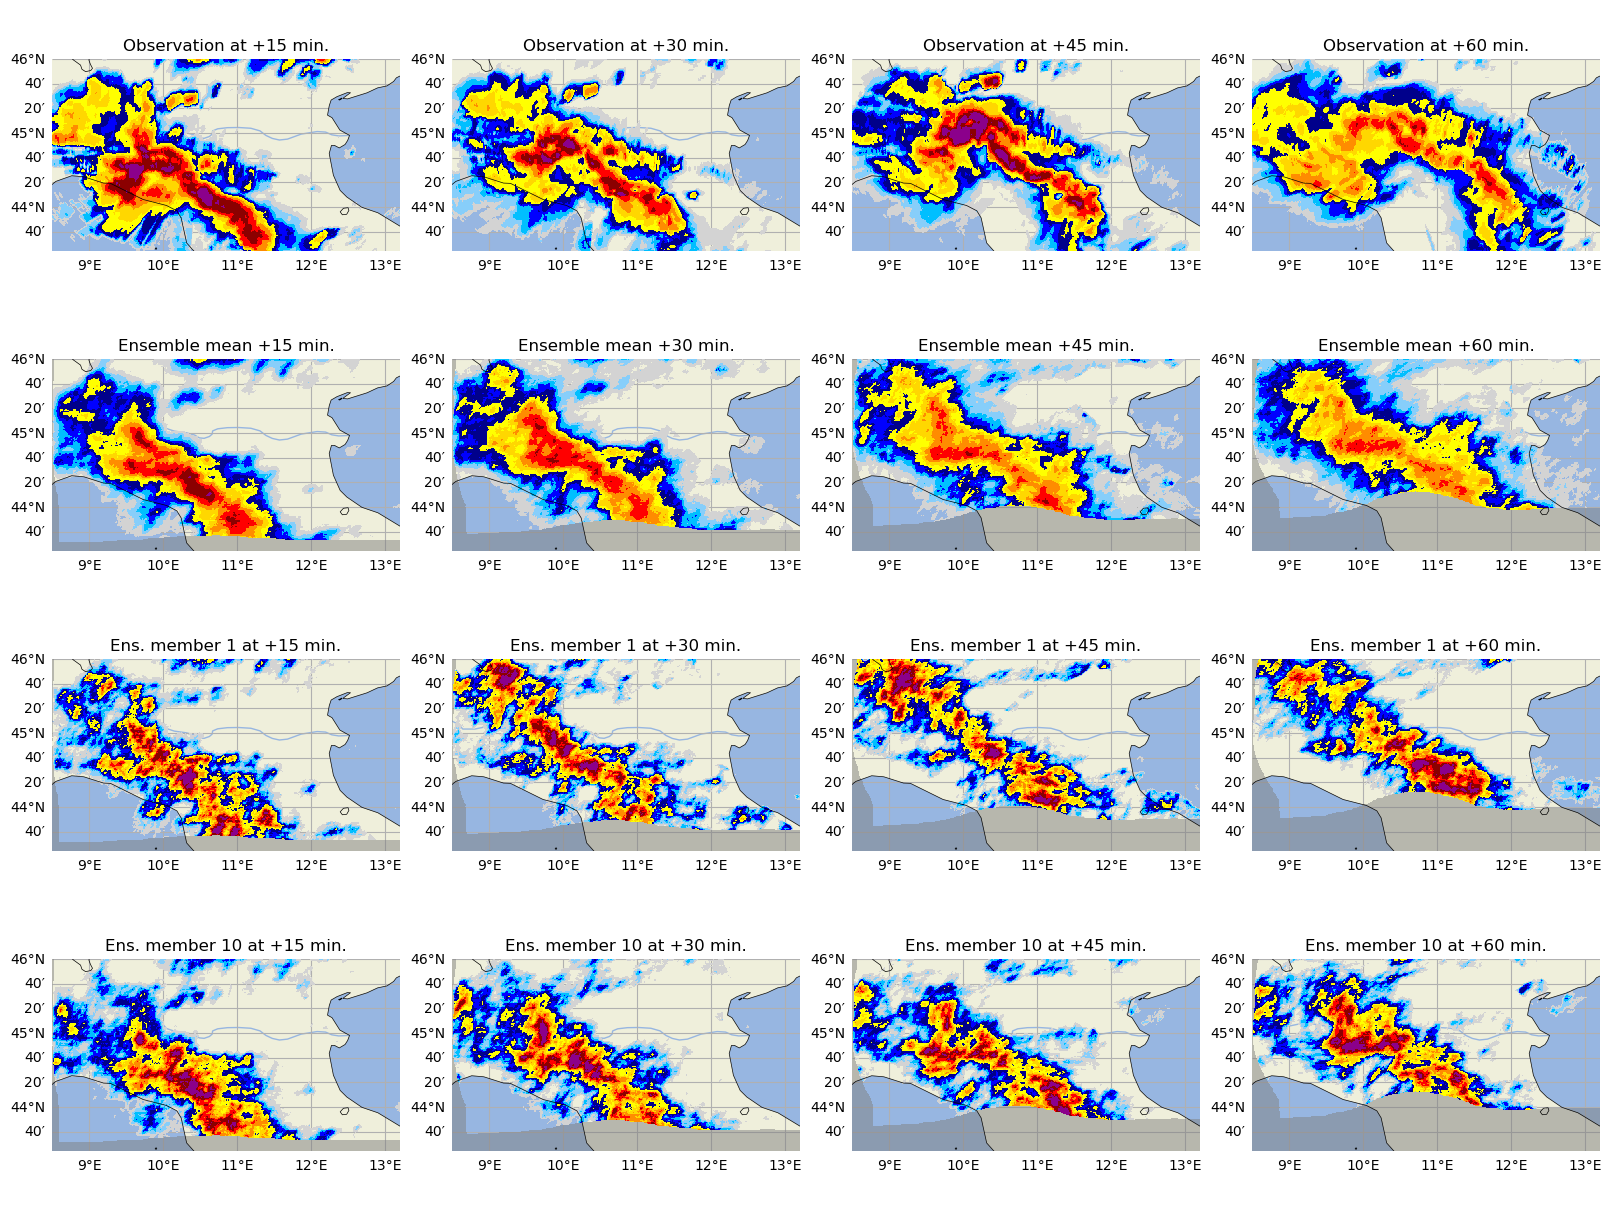

In [20]:
fig = plt.figure(figsize=(16, 12), layout="constrained")
map_kwargs = {"drawlonlatlines": True}

# First plot the observations
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 1 + i); ax.axis("off")
    plot_precip_field(
        precip_obs_mmh[j], 
        geodata=metadata, 
        colorscale="STEPS-NL", 
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Observation at +{(j + 1) * 15} min."
        )

# We'll plot the ensemble mean for four lead times
precip_forecast_mean = np.mean(precip_forecast[:, :, :, :], axis=0)

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 5 + i); ax.axis("off")
    plot_precip_field(
        precip_forecast_mean[j], 
        geodata=metadata, 
        colorscale="STEPS-NL", 
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Ensemble mean +{(j + 1) * 15} min."
        )
    
# Then, plot some realizations
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 9 + i); ax.axis("off")
    plot_precip_field(
        precip_forecast[0,j], 
        geodata=metadata, 
        colorscale="STEPS-NL", 
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Ens. member 1 at +{(j + 1) * 15} min."
        )
    
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 13 + i); ax.axis("off")
    plot_precip_field(
        precip_forecast[9,j], 
        geodata=metadata, 
        colorscale="STEPS-NL", 
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Ens. member 10 at +{(j + 1) * 15} min."
        )

plt.show()



As you can see from the two shown members of the ensemble, the stochastic forecast mantains the same variance as in the observed rainfall field. Hence, it gives a less smoothed outcome than the ensemble mean and also preserves high-intensity rainfall cells. Keep this in mind for the verification part where we will use verification metrics that can take the entire ensemble into account. 

In addition, we can also plot the probability of exceedance for a given threshold (1.0 mm/h in this example). See below:

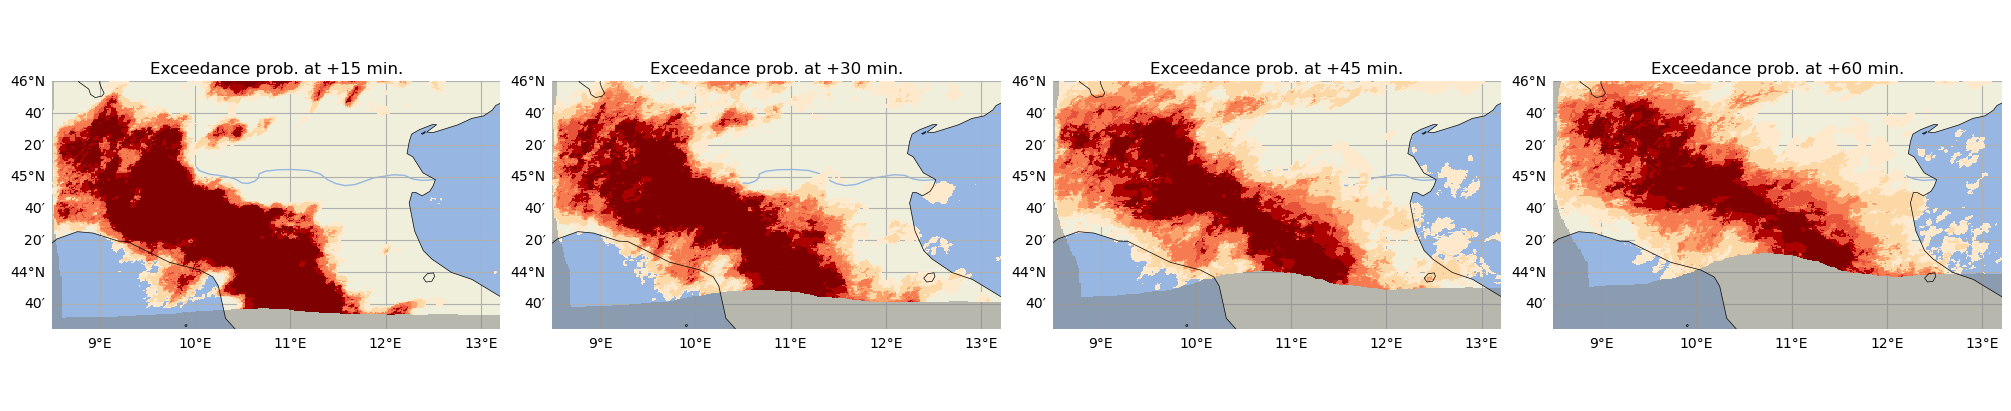

In [21]:
# Then plot the probability of exceeding 1 mm/h
fig = plt.figure(figsize=(20, 4), layout="constrained")
map_kwargs = {"drawlonlatlines": True}

for i, j in enumerate(range(0, 4, 1)):
  # Compute exceedence probabilities for a 1.0 mm/h threshold
  P = excprob(precip_forecast[:, j, :, :], 1.0)
  ax = fig.add_subplot(1, 4, 1 + i); ax.axis("off")
  plot_precip_field(
      P, 
      geodata=metadata, 
      ptype="prob",
      units="mm/h", 
      probthr=0.5,
      colorbar=False,
      map_kwargs=map_kwargs,
      ax=ax,
      title=f"Exceedance prob. at +{(j + 1) * 15} min."
      )

plt.show()


### Ensemble forecast verification
Pysteps includes a number of verification metrics to help users to analyze the general characteristics of the nowcasts in terms of consistency and quality (or goodness). In contrast to the verification of the deterministic nowcast, we have a 10-member ensemble that we want to verify. As every member contains valuable information, it is better not to use the deterministic verification metrics on the ensemble mean, but to use a metric that can take the entire ensemble into account. 

Therefore, we will focus on the CRPS (continuous ranked probability score), which you can see as the mean absolute error of the ensemble. It compares the cdf of the ensemble with the observed rainfall. 

In addition, we will verify our probabilistic forecasts using the ROC curve, reliability diagrams, and rank histograms, as implemented in the [verification module](https://pysteps.readthedocs.io/en/latest/pysteps_reference/verification.html) of pysteps.

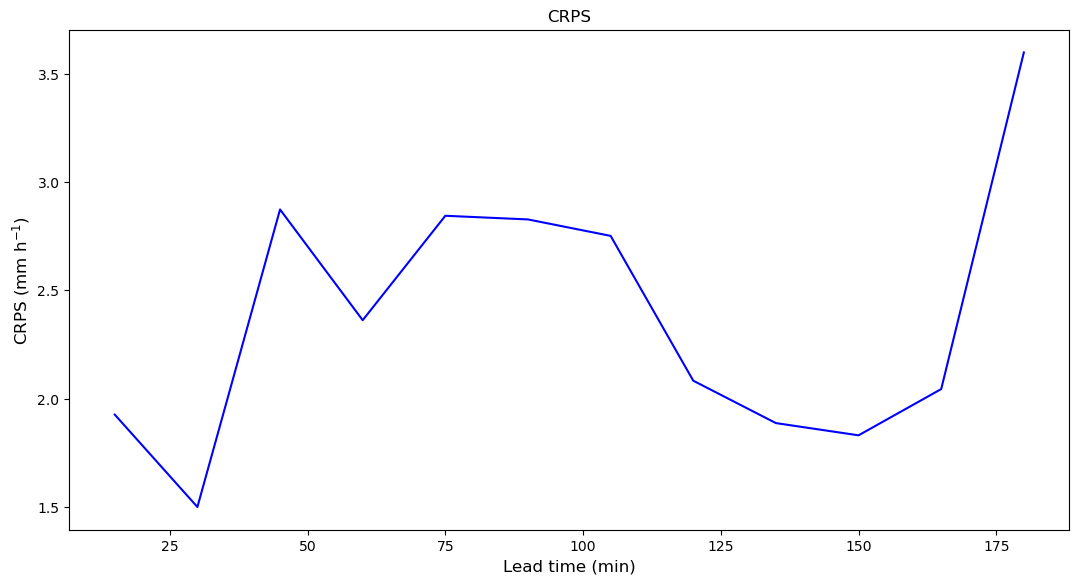

In [23]:
from pysteps import verification
from pysteps.postprocessing import ensemblestats

# Determine the CRPS
CRPS = []
for lt in range(n_leadtimes):
    CRPS.append(verification.probscores.CRPS(precip_forecast[:,lt,:,:],precip_obs_mmh[lt,:,:]))

# Plot it
fig = plt.figure(figsize = (10,5))
fig1 = fig.add_gridspec(1, 1, bottom = 0.0, top = 1.00, left = 0.0, right = 1.0) 
ax1 = fig.add_subplot(fig1[0,0])

# Plot the CRPS for both lead times
ax1.plot(
    (np.arange(n_leadtimes)+1)*15,
    CRPS,
    color="blue",
    )

ax1.set_xlabel("Lead time (min)", fontsize=12)
ax1.set_ylabel(r"CRPS (mm h$^{-1}$)", fontsize=12)

ax1.set_title("CRPS")

plt.show()


The [examples gallery](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_ensemble_verification.html#sphx-glr-auto-examples-plot-ensemble-verification-py) contains some ensemble verification examples that you could follow. For the subsequent verification metrics, we'll focus on a exceedance threshold of 1 mm/h. Try out some other thresholds and see how this influences the results.

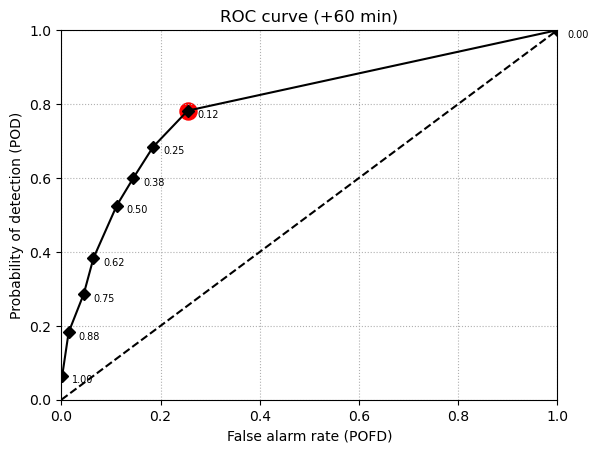

In [28]:
# We start with determining the exceedance probability in the forecast for a
# threshold of 1 mm/h for 1-h lead time (the last lead time in the forecast).
lead_time_index = 3

probability_forecast = ensemblestats.excprob(
    precip_forecast[:, lead_time_index, :, :], 
    1.0, 
    ignore_nan=True)

# ROC curve
roc = verification.ROC_curve_init(1.0, n_prob_thrs=9)
verification.ROC_curve_accum(
    ROC=roc, 
    P_f=probability_forecast, 
    X_o=precip_obs_mmh[lead_time_index, :, :],
    )
fig, ax = plt.subplots()
verification.plot_ROC(roc, ax, opt_prob_thr=True)
ax.set_title("ROC curve (+%i min)" % ((lead_time_index+1) * timestep))
plt.show()

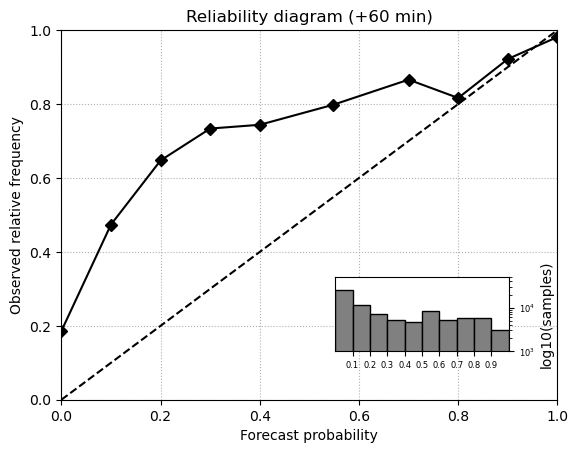

In [29]:
# Reliability diagram
reldiag = verification.reldiag_init(1.0)
verification.reldiag_accum(
    reldiag=reldiag, 
    P_f=probability_forecast, 
    X_o=precip_obs_mmh[lead_time_index, :, :],
)
fig, ax = plt.subplots()
verification.plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram (+%i min)" % ((lead_time_index+1) * timestep))
plt.show()

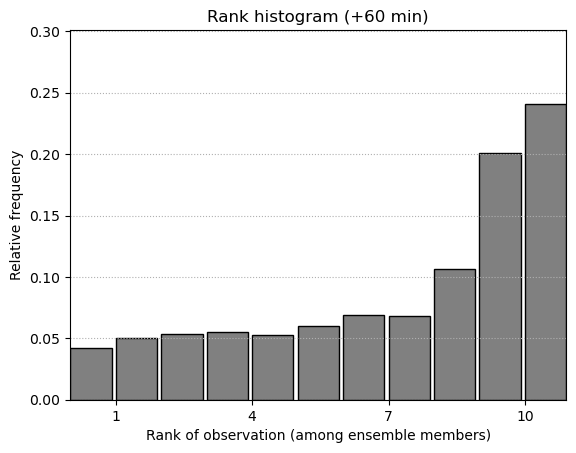

In [30]:
# Rank histogram
rankhist = verification.rankhist_init(precip_forecast.shape[0], 1.0)
verification.rankhist_accum(
    rankhist, 
    precip_forecast[:, lead_time_index, :, :], 
    precip_obs_mmh[lead_time_index, :, :]
    )
fig, ax = plt.subplots()
verification.plot_rankhist(rankhist, ax)
ax.set_title("Rank histogram (+%i min)" % ((lead_time_index+1) * timestep))
plt.show()